In [1]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
#import gender_guess.detector as gender
#from sklearn.preprocessing import Imputer
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from  sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline 

In [2]:
    genuine_users = pd.read_csv("users (3).csv")
    fake_users = pd.read_csv("fusers (3).csv")
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]

In [3]:
lang_list = list(enumerate(np.unique(x['lang'])))   
lang_dict = { name : i for i, name in lang_list }             
x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)  
feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','lang_code']
x=x.loc[:,feature_columns_to_use]

In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [5]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)


    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [7]:

def train(X_train,y_train,X_test):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    X_train=preprocessing.scale(X_train)
    X_test=preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    cvk = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
    classifier = SVC()
    clf = GridSearchCV(classifier,param_grid=param,cv=cvk)
    clf.fit(X_train,y_train)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train,y_train)
    # Estimate score
    scores = model_selection.cross_val_score(clf.best_estimator_, X_train,y_train, cv=5)
    print (scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel,&\gamma %6f$)' %clf.best_estimator_.gamma
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test,y_pred
     

In [8]:
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)


The best classifier is:  SVC(gamma=10.0)
[0.92682927 0.93569845 0.92682927 0.94900222 0.94444444]
Estimated score: 0.93656 (+/- 0.00451)


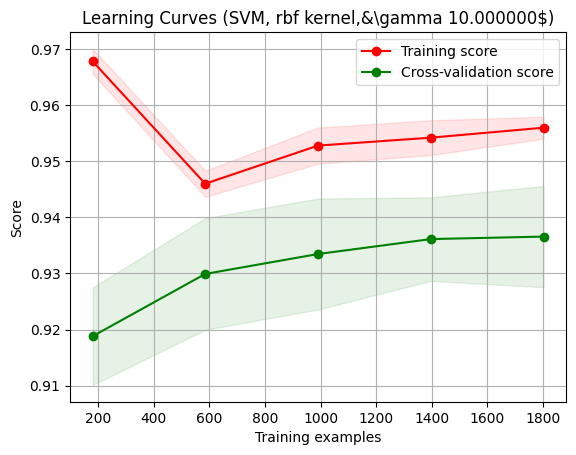

In [9]:
y_test,y_pred = train(X_train,y_train,X_test)

In [10]:
accuracy_score(y_test, y_pred)

0.9343971631205674

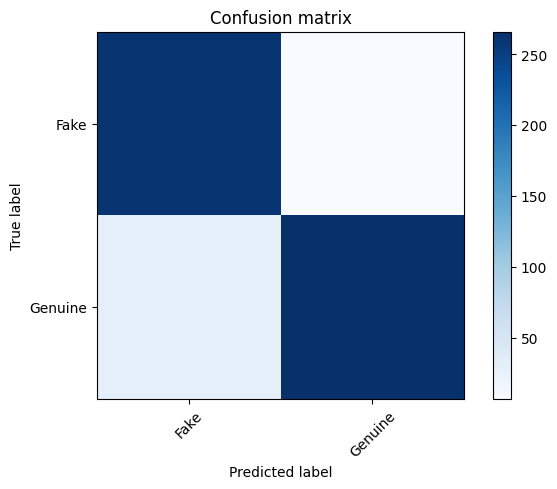

In [11]:
cm=confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

In [12]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.90      0.97      0.93       268
     Genuine       0.97      0.90      0.93       296

    accuracy                           0.93       564
   macro avg       0.94      0.94      0.93       564
weighted avg       0.94      0.93      0.93       564



False Positive rate:  [0.        0.0261194 1.       ]
True Positive rate:  [0.         0.89864865 1.        ]


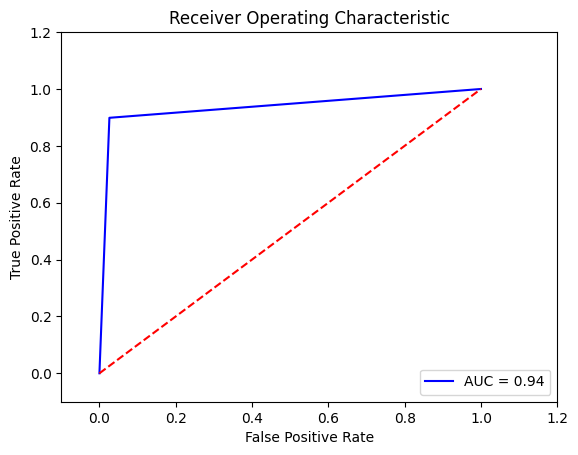

In [13]:
plot_roc_curve(y_test, y_pred)